In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, roc_auc_score, auc
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
sns.set()
random.seed(42)
np.random.seed(42)
pd.set_option('chained_assignment', None)

### Memory Based Collaborative Filtering by Similarity Matrix (Model Baseline)

In [2]:
dfFull = pd.read_csv(r"C:\Users\blake\Documents\Springboard\Github\Capstone3\Data\ContentMatrix2Test.csv", index_col=0)
dfFull.shape

(85020, 388)

In [3]:
dfFull.head()

,userID,gameName,playHours,rating,appid,developer,publisher,1980s,1990's,2.5D,...,Snow,Snowboarding,Social Deduction,Video Production,Vikings,Warhammer 40K,Werewolves,Bikes,Card Battler,Deckbuilding
0,48028873,100% orange juice,1.8,3.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88525821,100% orange juice,0.9,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93644606,100% orange juice,3.1,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,115996656,100% orange juice,2.5,3.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125017535,100% orange juice,0.7,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convert Data into user-item interaction matrix

In [4]:
reducedMatrix = dfFull.pivot(index='userID', columns='gameName', values='rating')
reducedMatrix.head()

gameName,100% orange juice,7 days to die,8bitmmo,a story about my uncle,ace arena cyber evolution,ace of spades,adventure capitalist,afterfall insanity extended edition,aftermath,age of chivalry,...,worms ultimate mayhem,xblades,xcom apocalypse,xcom enemy unknown,xcom enemy within,xcom terror from the deep,xcom ufo defense,yet another zombie defense,you have to win the game,zombies monsters robots
userID,,,,,,,,,,,,,,,,,,,,,
86540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
298950,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN
561758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
975449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN
1936551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Examine matrix sparcity. Roughly 10% of the cells are filled which is pretty good.

In [5]:
print("Matrix Sparcity:", reducedMatrix.isna().values.sum() / reducedMatrix.size)

Matrix Sparcity: 0.8926677776094532


In [6]:
reducedMatrix.shape, reducedMatrix.size

((984, 805), 792120)

In [7]:
reducedMatrix.notnull().values.sum() / reducedMatrix.size

0.10733222239054689

By reducing the size of the matrix, modeling will be faster, and sparcity will be reduced

#### Split Reduced Data into Train and Test
Randomly select 20% of each user's ratings and put them in the test set.

In [8]:
# Reduce dfFull to only records that can be found in the reduced matrix
dfReduced = dfFull.loc[(dfFull.userID.isin(reducedMatrix.index) & (dfFull.gameName.isin(reducedMatrix.columns)))]
dfReduced.userID.unique().shape, dfReduced.gameName.unique().shape

((984,), (805,))

In [9]:
def train_test(users, df):
    '''
    For each user in reduced df, set the column value for train-test to "test" for a random selection of 20% of their entries
    if rand is True.
    '''
    
    # Create a new column in the df and set all values to train
    df['split'] = 'train'
    
    for i in users:
        # For each user in the list of unique users, create a df of all their ratings, and an array of thier indicies
        userDf = df.loc[df.userID==i]
        userInds = userDf.index.values
        size = round(len(userInds)*0.2)
        
        testInds = np.random.choice(userInds, size=size, replace=False)       
        userDf.loc[userDf.index.isin(testInds), 'split'] = 'test'
        df.loc[df.userID==i] = userDf

    
    return df

In [10]:
%%time
users = dfReduced.userID.unique()
dfReduced = train_test(users, dfReduced)

Wall time: 46.8 s


In [11]:
dfReduced.shape, dfReduced.loc[dfReduced.split=='test'].shape

((85020, 389), (17009, 389))

In [12]:
UserTrain = dfReduced.loc[dfReduced.split=='train'].pivot(index='userID', columns='gameName', values='rating')
UserTest = dfReduced.loc[dfReduced.split=='test'].pivot(index='userID', columns='gameName', values='rating')

ItemTrain = UserTrain.T
ItemTest = UserTest.T

In [13]:
UserTrain.shape, UserTest.shape

((984, 805), (984, 805))

In [14]:
a = set(UserTrain.columns.values)
b = set(UserTest.columns.values)
b.difference(a)

set()

In [15]:
UserTest.drop(columns=b.difference(a), inplace=True)

Needed to check if there were any item columns in UserTest not present in UserTrain. Luckely there are not.

##### Zero Center Data function

In [16]:
def zero_center_svd(df, get_means=False, svd=False):
    '''Centers a df's rows around zero. Also performs SVD if needed'''
    output = []
    means = df.mean(axis=1)
    means.fillna(value=0, inplace=True)
    
    centeredDf = df.sub(means, axis=0)
    centeredDf.fillna(value=0, inplace=True)
    
    output.append(centeredDf)
    
    if get_means==True:
        output.append(means.values.reshape(-1,1))
        
    if svd==True:
        U, E, Vt = svds(centeredDf)
        E = np.diag(E)
        M = np.dot(np.dot(U, E), Vt)
        
        svdDf = M + means.values.reshape(-1,1)
        svdDf = pd.DataFrame(svdDf, index=df.index, columns=df.columns)
        
        output.append(svdDf)
        
    return output

##### Create a function that gets a list of all index/column combinations for non nan values in a df

In [17]:
def validation_data(df):
    '''Function generates a list of indix and column pairs for all non-nan values in a df'''
    inds = []
    
    for i in list(df.columns):
        col_non_nan = df.loc[~df[i].isna(), i]
        
        for ind in list(col_non_nan.index):
            inds.append((ind, i))
    
    return inds

##### Function that evaluates SVD

In [18]:
def evaluate_SVD(predicted, test, inds):
    '''
    Get predicted values for each (index, column) pair in list of inds. Then compare predictions with actual values.
    '''
    predicted = np.array([predicted.loc[u, i] for (u, i) in inds])
    true = np.array([test.loc[u, i] for (u, i) in inds])
        
    return mean_squared_error(true, predicted, squared=False)

##### Create a Cross Validataion function
Calls valdiation, train_test, and zero center functions, in addition to the desired model class

In [19]:
def five_fold_CV(train, model=None, n=10, item=False, SVD=False, SVD_params=None, knn_method=None):
    '''
    Five fold cross validation
    '''
    
    metrics = []
    
    for i in range(5):
        
        # Call previously defined train_test function to split data for fold
        users = train.userID.unique()
        df = train_test(users, train)
        
        FoldTrain = df.loc[df.split=='train'].pivot(index='userID', columns='gameName', values='rating')
        FoldTest = df.loc[df.split=='test'].pivot(index='userID', columns='gameName', values='rating')
        
        # Tanspose data if the model is Item-based
        if item==True:
            FoldTrain = FoldTrain.T
            FoldTest = FoldTest.T
        
        # Ensure that there are no columns in the testing set not present in the training set
        a = set(FoldTrain.columns.values)
        b = set(FoldTest.columns.values)
        FoldTest.drop(columns=b.difference(a), inplace=True)
        
        # Call previously defined validation_data function to generate list of user-item index pairs for evaluation
        ValInds = validation_data(FoldTest)
        # Call previously defined zero_center_svd function to get zero centered trian data
        centeredTrain, means = zero_center_svd(FoldTrain, get_means=True)

        
        if SVD==True:
            
            # Generate SVD matrix
            U, E, Vt = svds(centeredTrain, k=SVD_params[0], which=SVD_params[1], solver=SVD_params[2])
            E = np.diag(E)
            M = np.dot(np.dot(U, E), Vt)
            
            svdDf = M + means
            svdDf = pd.DataFrame(svdDf, index=centeredTrain.index, columns=centeredTrain.columns)
            
            metrics.append(evaluate_SVD(svdDf, FoldTest, ValInds))
            continue
        
        
        elif model == 'CollabFilter':
            # Create CollabFilter object, fit and evaluate
            m = CollabFilter(centered_train=centeredTrain, raw_train=FoldTrain, test=FoldTest)
            m.prep()
            metrics.append(m.evaluate(ValInds, n))
        
        else:
            # Create KNN_filter object, fit and evaluate
            m = KNN_filter(raw_train=FoldTrain, centered_train=centeredTrain, test=FoldTest)
            metrics.append(m.evaluate(ValInds, n, method=knn_method, item=item))
            
    return np.mean(metrics)

##### Create a Grid Search Function
Calls the cross validation function

In [20]:
def Grid_Search(train, params=None, model=None, item=False, SVD=False, SVD_params=None, knn_method='regressor'):
    metric_results = []
    
    if SVD==False:
        for i in params:
            metric_results.append(five_fold_CV(train, model, n=i, item=item, knn_method=knn_method))
    
        return {'param':params, 'metric':metric_results}
    
    else:
        for i in SVD_params:
            metric_results.append(five_fold_CV(train, model, item=item, SVD=SVD, SVD_params=i))
            
        return {'params':SVD_params, 'metric':metric_results}

##### Create a class for memory based collaborative filtering

Basic memory based collaborative filtering. No actual model training involved. Primary purpose for creating this was to get a solid understanding of how collaborative filtering works.

In [21]:
inds1 = validation_data(UserTest)
centeredUser = zero_center_svd(UserTrain)[0]

In [22]:
class CollabFilter:
    def __init__(self, centered_train=None, raw_train=None, test=None):
        self.sim_matrix = None
        self.centered_train = centered_train
        self.raw_train = raw_train
        self.test = test
    
    def prep(self, metric_function='cosine'):
        '''Generate Similartiy Matrix for model'''
        if metric_function == 'cosine':
            self.sim_matrix = pd.DataFrame(cosine_similarity(self.centered_train), index=self.centered_train.index, columns=self.centered_train.index)
            
        elif metric_function == 'euclidean':
            distances = euclidean_distances(self.centered_train)
            d = np.full((distances.shape[0], 1), 1)
            self.sim_matrix = pd.DataFrame((d - distances), index=self.centered_train.index, columns=self.centered_train.index)
            
    
    def predict(self, u, i, n):
        '''
        Take row (u), column (i) and number of similar rows to aggregate (n) and return a prediction for u's rating of
        i.
        '''
        # Get the user_id of all users who actually rated the target item
        other_users = self.raw_train.loc[~self.raw_train[i].isna()].index.values
        
        # If there are fewer than n user ratings for i in the trainings set, then set i equal to the number of user ratings
        # for i in the training set
        if other_users.shape[0] < n:
            n = other_users.shape[0]
        
        # Limit the columns of the similarity matrix to users who rated the target item
        other_users = self.sim_matrix[other_users]
        
        # Get a sorted list of other user's similarity to the target user
        sim_users = other_users.loc[u].sort_values(ascending=False)
        
        # Select the top n similar users
        sim_users = sim_users.iloc[:n+1]
        
        # Predict rating of target user for item by averaging the ratings of most similar users
        prediction = self.raw_train.loc[self.raw_train.index.isin(sim_users.index), i].mean()
          
        return prediction
        
    
    def evaluate(self, inds, n):
        '''
        Get predicted values for each (index, column) pair in list of inds. Use n nearest neighbors to predict.
        Then compare predictions with actual values.
        '''
        predicted = np.array([self.predict(u, i, n) for (u, i) in inds])
        true = np.array([self.test.loc[u, i] for (u, i) in inds])
        
        
        return mean_squared_error(true, predicted, squared=False)

In [23]:
GridTrain = dfReduced.loc[dfReduced.split=='train']

In [25]:
%%time
# Grid Search test
GSrmse = Grid_Search(GridTrain, model='CollabFilter', params=[12, 13, 14])
GSrmse = pd.DataFrame(GSrmse)
GSrmse.sort_values(by='metric')

Wall time: 19min 9s


,param,metric
0,12,0.815676
2,14,0.815811
1,13,0.816187


In [26]:
%%time
# Fit model based on grid search results
colabGrid = CollabFilter(centered_train=centeredUser, raw_train=UserTrain, test=UserTest)
colabGrid.prep()
colabGridRmse = colabGrid.evaluate(inds1, 12)
print(colabGridRmse)

0.8055311038523103
Wall time: 30.4 s


In [25]:
%%time
#TEST
# Fit model based on grid search results
colabGrid = CollabFilter(centered_train=centeredUser, raw_train=UserTrain, test=UserTest)
colabGrid.prep()
colabGridRmse = colabGrid.evaluate(inds1, 15)
print(colabGridRmse)

1.031213576558587
Wall time: 16.9 s


In [24]:
inds2 = validation_data(ItemTest)
centeredItems, itemSVD = zero_center_svd(ItemTrain, svd=True)

In [60]:
%%time
# Item based filtering grid search
ItemGrid = Grid_Search(GridTrain, model='CollabFilter', params=[10, 20, 30], item=True)
ItemGrid = pd.DataFrame(ItemGrid)
ItemGrid.sort_values(by='metric')

Wall time: 20min 14s


,param,metric
2,30,0.822348
1,20,0.822576
0,10,0.828937


In [61]:
%%time
colab3 = CollabFilter(centered_train=centeredItems, raw_train=ItemTrain, test=ItemTest)
colab3.prep()
rmse3 = colab3.evaluate(inds2, 50)
print(rmse3)

0.8185741805258365
Wall time: 36.8 s


In [27]:
%%time
#TEST
colab3 = CollabFilter(centered_train=centeredItems, raw_train=ItemTrain, test=ItemTest)
colab3.prep()
rmse3 = colab3.evaluate(inds2, 50)
print(rmse3)

1.0712452033895032
Wall time: 12.2 s


For the basic memory based model, it seems that item-based filtering yields the best result.

### KNeighbors Collaborative Filter
Anouther memory based model, this time using sklearn KNNClassifier and KNNRegressor rather than just a similarity matrix. This model is a lot slower, and yields slightly better results. Additionally, using the KNNClassifier allows for use of sklearns roc_auc_score function.

In [25]:
centeredUser, trainSVD = zero_center_svd(UserTrain, svd=True)
test_inds = validation_data(UserTest)

In [26]:
class KNN_filter:
    def __init__(self, raw_train=None, centered_train=None, test=None):
        self.raw_train = raw_train
        self.centered_train = centered_train
        self.test = test
        self.inds = None
        
    
    def evaluate(self, inds, n, metric='cosine', method='regressor', item=False):
        '''
        Get predicted values for each (index, column) pair in list of inds. Use n nearest neighbors to predict.
        Then compare predictions with actual values.
        '''
        self.inds = inds
        
        if method=='classifier':
            predicted = []
            mask = []
            
            for i, v in enumerate(self.inds):
                temp_pred = self.fit_predict_knn(v[0], v[1], n, metric=metric, method=method)[0]
                
                # If the output of KNNClassifier.predict_proba() is less than 5, do not include that item in the list
                # of predictions and add False to mask
                if temp_pred.shape[0] != 3:
                    mask.append(False)
                else:
                    predicted.append(temp_pred)
                    mask.append(True)
            
            # Apply mask to list of validation indicies
            mask = np.array(mask)
            self.inds = np.array(self.inds)[mask]
            predicted = np.array(predicted)
            
            if item == True:
                true = np.array([self.test.loc[u, int(i)] for (u, i) in self.inds])
            else:
                true = np.array([self.test.loc[int(u), i] for (u, i) in self.inds])

            return roc_auc_score(true, predicted, multi_class='ovr')
        
        else:
            predicted = np.array([self.fit_predict_knn(u, i, n, metric=metric, method=method) for (u, i) in inds])
            true = np.array([self.test.loc[u, i] for (u, i) in inds])

        return mean_squared_error(true, predicted, squared=False)

    
    def fit_predict_knn(self, u, i, n=3, metric='cosine', method='regressor'):
        '''
        Take a user (u) and item (i) as input and train a KNN model using SVD imputed training df.
        The KNN will train for the specific item, and predict the value of that itme for user u. 
        '''    
        
        # Isolate target user's vector and drop the column for the target item
        target_vector = self.centered_train.loc[[u]].drop(columns=[i])
        

        # Create a vector of all non target user's ratings for the target item using the raw df (w/ nan)
        # Then filter the list for only non nan values
        others_y = self.raw_train.loc[:, i].drop(index=[u])
        others_y.dropna(inplace=True)
        
        
        # If there are fewer than n user ratings for i in the trainings set, then set i equal to the number of user ratings
        # for i in the training set
        if others_y.shape[0] < n:
            n = others_y.shape[0]

        
        # Create df of all other user's vectors with target column removed
        others_x = self.centered_train.drop(columns=[i], index=[u])        
        
        # Now filter df of other user vectors on the index of the target item vector
        others_x = others_x.loc[others_x.index.isin(others_y.index)]
        
        
        if method == 'classifier':
            knn = KNeighborsClassifier(n_neighbors=n, metric=metric, n_jobs=8)
            
            knn.fit(others_x, others_y)
            return knn.predict_proba(target_vector)
        
        else:
            knn = KNeighborsRegressor(n_neighbors=n, metric=metric, n_jobs=8)               
        
            knn.fit(others_x, others_y)
            return knn.predict(target_vector)

In [27]:
centeredFull = zero_center_svd(UserTrain)[0]

In [37]:
# Grid Search Test
GridSearchKNN = Grid_Search(dfReduced, params=[40, 50, 60], knn_method='classifier')
GridSearchKNN = pd.DataFrame(GridSearchKNN)
GridSearchKNN.sort_values(by='metric')

,param,metric
2,60,0.611685
1,50,0.614436
0,40,0.619614


In [36]:
# AUC score for classifier
knn0 = KNN_filter(raw_train=UserTrain, centered_train=centeredUser, test=UserTest)
rmseKnn = knn0.evaluate(test_inds, n=25, method='classifier')
print(rmseKnn)

0.6225722464779125


In [37]:
#TEST (rmse)
knn0 = KNN_filter(raw_train=UserTrain, centered_train=centeredUser, test=UserTest)
rmseKnn = knn0.evaluate(test_inds, n=20)
print(rmseKnn)

0.8013097578967348


In [38]:
# Item Grid Search Test
GridSearchKNN = Grid_Search(dfReduced, params=[40, 50, 60], item=True, knn_method='classifier')
GridSearchKNN = pd.DataFrame(GridSearchKNN)
GridSearchKNN.sort_values(by='metric')

,param,metric
1,50,0.620791
2,60,0.621511
0,40,0.629073


In [27]:
item_testInds = validation_data(ItemTest)

In [129]:
%%time
knn3 = KNN_filter(raw_train=ItemTrain, centered_train=centeredItems, test=ItemTest)
rmseKnn3 = knn3.evaluate(item_testInds, n=50, method='classifier', item=True)
print(rmseKnn3)

0.6103326720144409
Wall time: 4min 24s


In [33]:
%%time
#TEST
knn3 = KNN_filter(raw_train=ItemTrain, centered_train=centeredItems, test=ItemTest)
rmseKnn3 = knn3.evaluate(item_testInds, n=50, method='classifier', item=True)
print(rmseKnn3)

0.5516179414883775
Wall time: 4min 42s


Again item-based filtering seems to be slightly better. Overall this model is still pretty bad, auc is just slightly over 50%.

### SVD
Basic SVD, no actual training involved.

In [337]:
def evaluate(predicted, test, inds):
    '''
    Get predicted values for each (index, column) pair in list of inds. Then compare predictions with actual values.
    '''
    predicted = np.array([predicted.loc[u, i] for (u, i) in inds])
    true = np.array([test.loc[u, i] for (u, i) in inds])
        
    return mean_squared_error(true, predicted, squared=False)

In [338]:
%%time
# SVD user based grid search

k = [3, 6, 9]
which = ['LM', 'SM']
solver = ['arpack', 'lobpcg']

SVDp = list(product(k, which, solver))


userSVD = Grid_Search(GridTrain, SVD=True, SVD_params=SVDp)
userSVD = pd.DataFrame(userSVD)
userSVD.sort_values(by='metric')

Wall time: 46min 8s


,params,metric
9,"(9, LM, lobpcg)",0.799864
4,"(6, LM, arpack)",0.800116
8,"(9, LM, arpack)",0.801577
5,"(6, LM, lobpcg)",0.802037
1,"(3, LM, lobpcg)",0.805102
0,"(3, LM, arpack)",0.805892
2,"(3, SM, arpack)",0.825640
11,"(9, SM, lobpcg)",0.826083
7,"(6, SM, lobpcg)",0.826229
6,"(6, SM, arpack)",0.826305


Results are better than the two previous memory based models.

# Surprise Library
Next I'll use the suprise library of recommender systems.

### Basic User Based Collaborative Filtering

In [60]:
from collections import defaultdict
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from surprise import SVD, SVDpp, KNNBasic, KNNWithMeans, BaselineOnly, KNNBaseline, SVDpp, NMF, SlopeOne, CoClustering

In [61]:
dfReduced.head()

,userID,gameName,playHours,rating,appid,developer,publisher,1980s,1990's,2.5D,...,Snowboarding,Social Deduction,Video Production,Vikings,Warhammer 40K,Werewolves,Bikes,Card Battler,Deckbuilding,split
0,48028873,100% orange juice,1.8,3.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
1,88525821,100% orange juice,0.9,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,93644606,100% orange juice,3.1,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,115996656,100% orange juice,2.5,3.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,125017535,100% orange juice,0.7,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [62]:
# Convert df into suprise data object using Reader()
UserTrainData = dfReduced.loc[dfReduced.split=='train', ['userID', 'gameName', 'rating']]
UserTestData = dfReduced.loc[dfReduced.split=='test', ['userID', 'gameName', 'rating']]
UserTrainData.rename(columns={'rating':'raw_rating'})
UserTestData.rename(columns={'rating':'raw_rating'})

reader = Reader(rating_scale=(1,5))
Traindata = Dataset.load_from_df(UserTrainData, reader)
Testdata = Dataset.load_from_df(UserTestData, reader)

# Do the same with item based data rather than user based
dfReducedItems = pd.concat([dfReduced['gameName'], dfReduced['userID'], dfReduced['rating'], dfReduced['split']], axis=1)
ItemTrainData = dfReducedItems.loc[dfReducedItems.split=='train', ['gameName', 'userID', 'rating']]
ItemTestData = dfReducedItems.loc[dfReducedItems.split=='test', ['gameName', 'userID', 'rating']]

ItemTrain = Dataset.load_from_df(ItemTrainData, reader)
ItemTest = Dataset.load_from_df(ItemTestData, reader)

In [63]:
# Define a function that takes training/testing data and a model, then fits and evaluates the model
def sprs(model, train, test):
    '''
    Fits and predicts using given suprise data and model. Then extracts values from testing/prediction 
    data and returns them as list
    '''
    model = model
    model.fit(train)
    pred = model.test(test)
    
    test_vals = [i[2] for i in test]
    pred_vals = [i[3] for i in pred]
    
    return test_vals, pred_vals

In [64]:
# User based train and test sets
train = Traindata.build_full_trainset()
test = Traindata.construct_testset(Testdata.raw_ratings)

results = []

In [65]:
type(train), type(test)

(surprise.trainset.Trainset, list)

In [345]:
%%time
for i in [SVD, SVDpp, KNNBasic, KNNWithMeans, BaselineOnly, KNNBaseline, NMF, SlopeOne, CoClustering]:
    testVal, pred = sprs(i(), train, test)
    results.append(mean_squared_error(testVal, pred, squared=False))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\blake\AppData\Local\Temp/ipykernel_7560/1218681273.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  model.fit(train)
C:\Users\blake\AppData\Local\Temp/ipykernel_7560/1218681273.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional 

Wall time: 1min 29s


In [346]:
names = ['SVD', 'SVDpp', 'KNNBasic', 'KNNWithMeans', 'BaselineOnly', 'KNNBaseline', 'NMF', 'SlopeOne', 'CoClustering']
res = {'model':names, 'RMSE':results}
UserResultsDF = pd.DataFrame(res)
UserResultsDF.sort_values(by='RMSE')

,model,RMSE
5,KNNBaseline,0.763556
3,KNNWithMeans,0.766388
7,SlopeOne,0.766647
1,SVDpp,0.767961
4,BaselineOnly,0.771407
0,SVD,0.774748
6,NMF,0.779750
8,CoClustering,0.780628
2,KNNBasic,0.790979


In [347]:
#TEST
names = ['SVD', 'SVDpp', 'KNNBasic', 'KNNWithMeans', 'BaselineOnly', 'KNNBaseline', 'NMF', 'SlopeOne', 'CoClustering']
res = {'model':names, 'RMSE':results}
UserResultsDF = pd.DataFrame(res)
UserResultsDF.sort_values(by='RMSE')

,model,RMSE
5,KNNBaseline,0.763556
3,KNNWithMeans,0.766388
7,SlopeOne,0.766647
1,SVDpp,0.767961
4,BaselineOnly,0.771407
0,SVD,0.774748
6,NMF,0.779750
8,CoClustering,0.780628
2,KNNBasic,0.790979


Running through the default parameters for each model it looks like the KNN models perfomr the best for user-based filtering.

In [348]:
%%time
# Now repeate with Item based data
Itrain = ItemTrain.build_full_trainset()
Itest = ItemTrain.construct_testset(ItemTest.raw_ratings)

ItemResults = []

for i in [SVD, SVDpp, KNNBasic, KNNWithMeans, BaselineOnly, KNNBaseline, NMF, SlopeOne, CoClustering]:
    testVal, pred = sprs(i(), Itrain, Itest)
    ItemResults.append(mean_squared_error(testVal, pred, squared=False))
    

names = ['SVD', 'SVDpp', 'KNNBasic', 'KNNWithMeans', 'BaselineOnly', 'KNNBaseline', 'NMF', 'SlopeOne', 'CoClustering']
res = {'model':names, 'RMSE':ItemResults}
ItemResultsDF = pd.DataFrame(res)
ItemResultsDF.sort_values(by='RMSE')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\blake\AppData\Local\Temp/ipykernel_7560/1218681273.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  model.fit(train)
C:\Users\blake\AppData\Local\Temp/ipykernel_7560/1218681273.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional 

Wall time: 2min 1s


,model,RMSE
5,KNNBaseline,0.763879
3,KNNWithMeans,0.766350
1,SVDpp,0.768979
7,SlopeOne,0.770037
4,BaselineOnly,0.771614
0,SVD,0.774847
8,CoClustering,0.780317
6,NMF,0.780771
2,KNNBasic,0.783888


In [349]:
%%time
#TEST
# Now repeate with Item based data
Itrain = ItemTrain.build_full_trainset()
Itest = ItemTrain.construct_testset(ItemTest.raw_ratings)

ItemResults = []

for i in [SVD, SVDpp, KNNBasic, KNNWithMeans, BaselineOnly, KNNBaseline, NMF, SlopeOne, CoClustering]:
    testVal, pred = sprs(i(), Itrain, Itest)
    ItemResults.append(mean_squared_error(testVal, pred, squared=False))
    

names = ['SVD', 'SVDpp', 'KNNBasic', 'KNNWithMeans', 'BaselineOnly', 'KNNBaseline', 'NMF', 'SlopeOne', 'CoClustering']
res = {'model':names, 'RMSE':ItemResults}
ItemResultsDF = pd.DataFrame(res)
ItemResultsDF.sort_values(by='RMSE')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\blake\AppData\Local\Temp/ipykernel_7560/1218681273.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  model.fit(train)
C:\Users\blake\AppData\Local\Temp/ipykernel_7560/1218681273.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional 

Wall time: 2min 1s


,model,RMSE
5,KNNBaseline,0.763879
3,KNNWithMeans,0.766350
1,SVDpp,0.769056
7,SlopeOne,0.770037
4,BaselineOnly,0.771614
0,SVD,0.774724
8,CoClustering,0.781116
6,NMF,0.782260
2,KNNBasic,0.783888


Item-based filtering yields slightly better results for default models. KNNBaseline seems to be the best performing model for both user and item based collabortive filtering. Next I'll try to tune a few of the Suprise models to improve their performance

### Random Search

In [34]:
def sprs_RandomSearch(param_grid, model, train, test):
    '''
    Funtion takes a param grid and a surprise model, them performs random search and scores it.
    Returns the RMSE, best model parameters, and the suprise prediction set.
    '''
    # Set up and fit the random search
    random_search = RandomizedSearchCV(model, param_grid, measures=['rmse', 'mae'], cv=5, n_iter=30, n_jobs=8)
    random_search.fit(train)
    algo = random_search.best_estimator['rmse']
    
    # With best set of params, fit and score model
    trainset = train.build_full_trainset()
    algo.fit(trainset)
    
    testset = train.construct_testset(test.raw_ratings)
    pred = algo.test(testset)
    
    return accuracy.rmse(pred), random_search.best_params, pred

In [352]:
%%time
# User Based KNNBasic grid search
KNNBaseline_params = {'k':list(range(50, 150)), 'sim_options':{'name':['cosine', 'pearson', 'msd'], 'user_based':[True]}}
KNNBaseline_rmse, KNNBaseline_bestParams, KNNBaseline_pred = sprs_RandomSearch(KNNBaseline_params, KNNBaseline, Traindata, Testdata)
KNNBaseline_rmse

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7634
Wall time: 57.3 s


0.7634125428943069

In [353]:
KNNBaseline_bestParams

{'rmse': {'k': 55, 'sim_options': {'name': 'msd', 'user_based': True}},
 'mae': {'k': 73, 'sim_options': {'name': 'pearson', 'user_based': True}}}

In [395]:
%%time
#TEST
# User Based KNNBasic random search
KNNBaseline_params = {'k':list(range(80, 120)), 'sim_options':{'name':['pearson'], 'user_based':[True]}}
KNNBaseline_rmse, KNNBaseline_bestParams, KNNBaseline_pred = sprs_RandomSearch(KNNBaseline_params, KNNBaseline, Traindata, Testdata)
KNNBaseline_rmse

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.7600
Wall time: 1min 36s


0.7599728078189325

In [396]:
#TEST
KNNBaseline_bestParams

{'rmse': {'k': 99, 'sim_options': {'name': 'pearson', 'user_based': True}},
 'mae': {'k': 85, 'sim_options': {'name': 'pearson', 'user_based': True}}}

In [356]:
%%time
# Item Based KNNBasic random search
KNNBaseline_params = {'k':list(range(40, 150)), 'sim_options':{'name':['cosine', 'pearson', 'msd'], 'user_based':[True]}}
KNNBaseline_rmse, KNNBaseline_bestParams, KNNBaseline_pred = sprs_RandomSearch(KNNBaseline_params, KNNBaseline, ItemTrain, ItemTest)
KNNBaseline_rmse

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7646
Wall time: 45 s


0.7646360429476152

In [357]:
KNNBaseline_bestParams

{'rmse': {'k': 76, 'sim_options': {'name': 'msd', 'user_based': True}},
 'mae': {'k': 76, 'sim_options': {'name': 'msd', 'user_based': True}}}

In [358]:
%%time
# SVD User based Random Search
param_grid = {'n_factors':list(range(50, 150)), 'n_epochs':list(range(10,100)), 'lr_all':np.arange(0.001, 0.01, 0.001)}
SVD_rmse, SVD_bestParams, SVD_pred = sprs_RandomSearch(param_grid, SVD, Traindata, Testdata)
SVD_rmse

RMSE: 0.7729
Wall time: 2min 20s


0.7729026202835744

In [359]:
SVD_bestParams

{'rmse': {'n_factors': 52, 'n_epochs': 96, 'lr_all': 0.001},
 'mae': {'n_factors': 52, 'n_epochs': 96, 'lr_all': 0.001}}

In [360]:
%%time
#TEST
# SVD User based Random Search
param_grid = {'n_factors':list(range(50, 150)), 'n_epochs':list(range(10,100)), 'lr_all':np.arange(0.001, 0.01, 0.001)}
SVD_rmse, SVD_bestParams, SVD_pred = sprs_RandomSearch(param_grid, SVD, Traindata, Testdata)
SVD_rmse

RMSE: 0.7766
Wall time: 2min 7s


0.776610903085251

In [361]:
#TEST
SVD_bestParams

{'rmse': {'n_factors': 83, 'n_epochs': 49, 'lr_all': 0.002},
 'mae': {'n_factors': 137, 'n_epochs': 88, 'lr_all': 0.008}}

In [362]:
%%time
# SVD Item based Random Search
param_grid = {'n_factors':list(range(30, 130)), 'n_epochs':list(range(10,100)), 'lr_all':np.arange(0.001, 0.01, 0.001)}
SVD_rmse, SVD_bestParams, SVD_pred = sprs_RandomSearch(param_grid, SVD, ItemTrain, ItemTest)
SVD_rmse

RMSE: 0.7744
Wall time: 1min 22s


0.7744231570071459

In [363]:
SVD_bestParams

{'rmse': {'n_factors': 65, 'n_epochs': 65, 'lr_all': 0.001},
 'mae': {'n_factors': 56, 'n_epochs': 98, 'lr_all': 0.001}}

In [364]:
%%time
# User Based SVD++ 
SVDpp_params = {'n_factors':list(range(5,40)), 'n_epochs':list(range(5, 50)), 'lr_all':np.arange(.001, .01, .001)}
SVDpp_rmse, SVDpp_bestParams, SVDpp_pred = sprs_RandomSearch(SVDpp_params, SVDpp, Traindata, Testdata)
SVDpp_rmse

RMSE: 0.7669
Wall time: 18min 58s


0.7669050840532305

In [365]:
SVDpp_bestParams

{'rmse': {'n_factors': 9, 'n_epochs': 29, 'lr_all': 0.005},
 'mae': {'n_factors': 24, 'n_epochs': 28, 'lr_all': 0.006}}

In [35]:
# Item Based SVD++
SVDpp_params = {'n_factors':list(range(5,40)), 'n_epochs':list(range(5, 50)), 'lr_all':np.arange(.001, .01, .001)}
SVDpp_rmse, SVDpp_bestParams, SVDpp_pred = sprs_RandomSearch(SVDpp_params, SVDpp, ItemTrain, ItemTest)
SVDpp_rmse

RMSE: 0.7633


0.7633281222974283

In [36]:
SVDpp_bestParams

{'rmse': {'n_factors': 10, 'n_epochs': 17, 'lr_all': 0.004},
 'mae': {'n_factors': 20, 'n_epochs': 39, 'lr_all': 0.005}}

After tuning the models SVD++ preforms better than KNN.

### Generate User Predictions
Using the best performing model in the suprise library (SVD++) I'll now generate a list of predictions for myself and five other friends to see how effective the recomendations are.

In [66]:
model = SVDpp(n_factors=10, n_epochs=17, lr_all=0.004)
model.fit(train)
pred = model.test(test)
accuracy.rmse(pred)

RMSE: 0.7637


0.7636680028953187

In [67]:
# Check precision@k for comparison with LighFM
# Code adapted from example in Suprise documentation 
# (https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k)

def precision_k(pred, k=10, threshold=2.5):
    user_pred_est = defaultdict(list)
    
    for uid, iid, true, est, detail in pred:
        user_pred_est[uid].append((est, true))
        
    precision = dict()
    
    for uid, ratings in user_pred_est.items():
        
        ratings.sort(key=lambda x: x[0], reverse=True)
        
        recommended_at_k = sum((est>=threshold) for (est, true) in ratings[:k])
        
        relevant_and_estimated_at_k = sum(((true>=threshold) and (est>=threshold) for (est, true) in ratings[:k]))
        
        precision[uid] = relevant_and_estimated_at_k / recommended_at_k if recommended_at_k!=0 else 0
    
    return precision

In [68]:
pATk = precision_k(pred)
p = np.mean(list(pATk.values()))
print('Precision@k:', p)

Precision@k: 0.043953252032520325


In [397]:
uids = [("Max", 76561198043116852), ("Sam", 76561198030495862), ("Flan", 76561198067694858),
        ("Ben", 76561198067474658), ("Julian", 76561198025619021), ("Blake", 76561198050349457)]

games = reducedMatrix.columns.values

for i in uids:
    
    recomendations = {'game':[], 'pred_score':[]}

    for g in games:
        pred = model.predict(i[1], g)
        recomendations['game'].append(pred[1])
        recomendations['pred_score'].append(pred[3])
    
    recomendation = pd.DataFrame(recomendations)
    recomendation.sort_values(by='pred_score', ascending=False, inplace=True)
    user_ids = dfReduced.loc[dfReduced.userID==i[1], 'gameName']
    recomendation = recomendation.loc[~recomendation.game.isin(user_ids)]
    
    recomendation.to_csv("KNNuser{}{}.csv".format(i[0], i[1]))

# LightFM with Steam Data
Final model will be created using LightFM. This model allows for both basic collabortive filtering and a hybrid approach that incorporates item features.

In [24]:
import lightfm as lt
import scipy
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score, precision_at_k
from lightfm.cross_validation import random_train_test_split

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [25]:
LFMdf = dfReduced.copy()

LFMdf.head()

,userID,gameName,playHours,rating,appid,developer,publisher,1980s,1990's,2.5D,...,Snowboarding,Social Deduction,Video Production,Vikings,Warhammer 40K,Werewolves,Bikes,Card Battler,Deckbuilding,split
0,48028873,100% orange juice,1.8,3.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test
1,88525821,100% orange juice,0.9,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,93644606,100% orange juice,3.1,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,115996656,100% orange juice,2.5,3.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,125017535,100% orange juice,0.7,2.0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [26]:
dfReduced.shape

(85020, 389)

#### Create train and test user interaction matricies
Unlike in previous models, the train and test matrix need to be the same shape containing only there respective interactions and zeros (ie. no interaction should be filled with 0 not nan)

In [27]:
# Prep train and test data
LFMtrain = LFMdf.copy()
LFMtrain.loc[LFMtrain.split=='test', 'rating'] = 0

LFMtest = LFMdf.copy()
LFMtest.loc[LFMdf.split=='train', 'rating'] = 0

In [28]:
LFMtrain.fillna(value=0, inplace=True)
LFMtest.fillna(value=0, inplace=True)
LFMtrain.shape, LFMtest.shape

((85020, 389), (85020, 389))

In [29]:
allInteractions = LFMdf.pivot(index='userID', values='rating', columns='appid')
allInteractions.fillna(value=0, inplace=True)

TrainInteractionsDF = LFMtrain[['userID', 'appid', 'rating']]
TrainInteractionsMatrix = LFMtrain.pivot(index='userID', values='rating', columns='appid')
TrainInteractionsMatrix.fillna(value=0, inplace=True)

TestInteractionsDF = LFMtest[['userID', 'appid', 'rating']]
TestInteractionsMatrix = LFMtest.pivot(index='userID', values='rating', columns='appid')
TestInteractionsMatrix.fillna(value=0, inplace=True)
TestInteractionsMatrix.head()

appid,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,100.0,130.0,...,389300.0,389570.0,391460.0,391540.0,391720.0,393380.0,417860.0,439700.0,1237950.0,1916830.0
userID,,,,,,,,,,,,,,,,,,,,,
86540,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298950,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
561758,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
975449,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1936551,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Item features
Feature matrix, with missing values again filled with 0 not nan

In [30]:
FeatureDF = dfReduced.drop(columns=['userID', 'gameName', 'playHours', 'rating', 'split'])
FeatureDF.fillna(value=0, inplace=True)
FeatureDF.head()

,appid,developer,publisher,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,3D,...,Snow,Snowboarding,Social Deduction,Video Production,Vikings,Warhammer 40K,Werewolves,Bikes,Card Battler,Deckbuilding
0,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,282800.0,Orange_Juice,Fruitbat Factory,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
FeatureDF.drop_duplicates(subset=['appid'], inplace=True)

In [32]:
developers = pd.get_dummies(FeatureDF['developer'])
publishers = pd.get_dummies(FeatureDF['publisher'])

In [33]:
FeatureDF = pd.concat([FeatureDF, developers, publishers], axis=1)
FeatureDF.drop(columns=['developer', 'publisher'], inplace=True)
FeatureDF.index = FeatureDF['appid']
FeatureDF.drop(columns=['appid'], inplace=True)
FeatureDF.head()

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,3D,3D Platformer,3D Vision,4 Player Local,...,Wizards of the Coast LLC,Wolfire Games,Xbox Game Studios,Young Horses,Zachtronics,Zeboyd Games,gamigo US Inc.,tinyBuild,tobyfox,Дмитриев Максим Константинович
appid,,,,,,,,,,,,,,,,,,,,,
282800.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
251570.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
250420.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
278360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
285580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
FeatureDF.shape

(812, 1160)

#### Now convert the interaction and feature maticies into scipy sparce matricies for modeling
Interactions need to be a coo_matrix and features a csr_matrix

In [35]:
SparceInteractions_train = scipy.sparse.coo_matrix(TrainInteractionsMatrix)
SparceInteractions_test = scipy.sparse.coo_matrix(TestInteractionsMatrix)

SparceFeatures = scipy.sparse.csr_matrix(FeatureDF.values)

#### Perform Grid Search to determine best hyper parameters
Define class for grid search and CV of LightFM model.

In [36]:
class LFMGridSearchCV:
    def __init__(self, interactions, parameters, itemFeatures=None):
        
        self.model = None
        self.parameters = parameters
        self.interactions = interactions
        self.train = None
        self.test = None
        self.itemFeatures = itemFeatures
        self.metrics = {'precision@K':[], 'auc':[]}
        self.aggregate_metrics = {'precision@K':[], 'auc':[]}
        
    def split(self):
        '''Uses LighFMs random_train_test_split function to split data into train/test sets for each fold'''
        self.train, self.test = random_train_test_split(self.interactions, random_state=42)
        
        
    def CV(self, parameters):
        '''Define, fit, and compute metrics for each fold'''
        self.model = lt.LightFM(no_components=parameters[0],
                                loss=parameters[1],
                                learning_schedule=parameters[2],
                                user_alpha=parameters[3],
                                item_alpha = parameters[4],
                                learning_rate=parameters[5],
                                random_state=42)
        
        self.model.fit(self.train, item_features=self.itemFeatures, epochs=10)
        
        self.metrics['precision@K'].append(precision_at_k(self.model, self.test, item_features=self.itemFeatures, k=10))
        self.metrics['auc'].append(auc_score(self.model, self.test, item_features=self.itemFeatures,))
    
    
    def GridSearch(self):
        '''
        Iterate through each set of input parameters and preform 5-fold CV. Agregate metircs accross all 5 folds for each
        set of parameters.
        '''
        for i in self.parameters:
        
            self.metrics = {'precision@K':[], 'auc':[]}
        
            for j in range(5):
                self.split()
                self.CV(i)
            
            self.aggregate_metrics['auc'].append(np.mean(self.metrics['auc']))
            self.aggregate_metrics['precision@K'].append(np.mean(self.metrics['precision@K']))
            

In [37]:
# List of parameters for grid search
no_components = [30, 35, 40, 45, 50, 55]
loss = ['warp']
learning_schedule = ['adagrad']
user_alpha = [1e-3]
item_alpha = [0]
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05]

parameters = list(product(no_components, loss, learning_schedule, user_alpha, item_alpha, learning_rate))

In [90]:
%%time
# Grid Search with just collaborative filtering
# 0, free, med, mean
LFMSearch = LFMGridSearchCV(SparceInteractions_train, parameters)
LFMSearch.GridSearch()

Wall time: 11min 58s


In [91]:
metrics = LFMSearch.aggregate_metrics
metrics['params'] = LFMSearch.parameters

metricsDF = pd.DataFrame(metrics)

In [92]:
metricsDF.sort_values(by='precision@K', ascending=False)

,precision@K,auc,params
17,0.104476,0.789917,"(45, warp, adagrad, 0.001, 0, 0.03)"
7,0.104476,0.788864,"(35, warp, adagrad, 0.001, 0, 0.03)"
21,0.103967,0.776684,"(50, warp, adagrad, 0.001, 0, 0.02)"
16,0.103764,0.771910,"(45, warp, adagrad, 0.001, 0, 0.02)"
6,0.103764,0.772898,"(35, warp, adagrad, 0.001, 0, 0.02)"
2,0.103561,0.784368,"(30, warp, adagrad, 0.001, 0, 0.03)"
27,0.103459,0.797140,"(55, warp, adagrad, 0.001, 0, 0.03)"
11,0.103357,0.776150,"(40, warp, adagrad, 0.001, 0, 0.02)"
1,0.103154,0.765611,"(30, warp, adagrad, 0.001, 0, 0.02)"
26,0.103052,0.778973,"(55, warp, adagrad, 0.001, 0, 0.02)"


In [93]:
metricsDF.sort_values(by='auc', ascending=False)

,precision@K,auc,params
28,0.101119,0.804415,"(55, warp, adagrad, 0.001, 0, 0.04)"
19,0.095219,0.804312,"(45, warp, adagrad, 0.001, 0, 0.05)"
24,0.091353,0.804233,"(50, warp, adagrad, 0.001, 0, 0.05)"
29,0.091760,0.804214,"(55, warp, adagrad, 0.001, 0, 0.05)"
14,0.097050,0.802463,"(40, warp, adagrad, 0.001, 0, 0.05)"
9,0.097355,0.799778,"(35, warp, adagrad, 0.001, 0, 0.05)"
23,0.100509,0.799765,"(50, warp, adagrad, 0.001, 0, 0.04)"
13,0.101933,0.799363,"(40, warp, adagrad, 0.001, 0, 0.04)"
18,0.101526,0.798851,"(45, warp, adagrad, 0.001, 0, 0.04)"
4,0.101119,0.797899,"(30, warp, adagrad, 0.001, 0, 0.05)"


In [280]:
%%time
#TEST
# Grid Search with just collaborative filtering
LFMSearch = LFMGridSearchCV(SparceInteractions_train, parameters)
LFMSearch.GridSearch()

Wall time: 13min 3s


In [281]:
#TEST
metrics = LFMSearch.aggregate_metrics
metrics['params'] = LFMSearch.parameters

metricsDF = pd.DataFrame(metrics)

In [285]:
#TEST
# w/ free
metricsDF.sort_values(by='auc', ascending=False)

,precision@K,auc,params
29,0.092065,0.809313,"(55, warp, adagrad, 0.001, 0, 0.05)"
24,0.093082,0.807851,"(50, warp, adagrad, 0.001, 0, 0.05)"
19,0.095117,0.807758,"(45, warp, adagrad, 0.001, 0, 0.05)"
28,0.097457,0.806753,"(55, warp, adagrad, 0.001, 0, 0.04)"
23,0.097965,0.805875,"(50, warp, adagrad, 0.001, 0, 0.04)"
9,0.096846,0.805309,"(35, warp, adagrad, 0.001, 0, 0.05)"
14,0.097355,0.805076,"(40, warp, adagrad, 0.001, 0, 0.05)"
18,0.099186,0.804189,"(45, warp, adagrad, 0.001, 0, 0.04)"
4,0.099797,0.803800,"(30, warp, adagrad, 0.001, 0, 0.05)"
8,0.101221,0.801925,"(35, warp, adagrad, 0.001, 0, 0.04)"


In [82]:
%%time
# Now find best hyperparameters for a model that includes item featrues
no_components = [10, 20, 30, 40]
loss = ['warp']
learning_schedule = ['adagrad']
user_alpha = [0, 1e-3]
item_alpha = [0, 1e-3]
learning_rate = [0.01, 0.02, 0.03, 0.04]

parameters = list(product(no_components, loss, learning_schedule, user_alpha, item_alpha, learning_rate))


# Grid Search with just collaborative filtering
LFMSearch = LFMGridSearchCV(SparceInteractions_train, parameters, itemFeatures=SparceFeatures)
LFMSearch.GridSearch()

metrics = LFMSearch.aggregate_metrics
metrics['params'] = LFMSearch.parameters

metricsDF = pd.DataFrame(metrics)

metricsDF.sort_values(by='precision@K', ascending=False)

Wall time: 1h 49min 26s


,precision@K,auc,params
10,0.085554,0.696435,"(10, warp, adagrad, 0.001, 0, 0.03)"
14,0.085554,0.693771,"(10, warp, adagrad, 0.001, 0.001, 0.03)"
15,0.085351,0.702332,"(10, warp, adagrad, 0.001, 0.001, 0.04)"
44,0.084741,0.675685,"(30, warp, adagrad, 0.001, 0.001, 0.01)"
11,0.084130,0.700852,"(10, warp, adagrad, 0.001, 0, 0.04)"
...,...,...,...
63,0.067752,0.704878,"(40, warp, adagrad, 0.001, 0.001, 0.04)"
59,0.064598,0.706669,"(40, warp, adagrad, 0.001, 0, 0.04)"
55,0.063988,0.702651,"(40, warp, adagrad, 0, 0.001, 0.04)"
50,0.063784,0.701973,"(40, warp, adagrad, 0, 0, 0.03)"


In [86]:
metricsDF.sort_values(by='auc', ascending=False)

,precision@K,auc,params
59,0.064598,0.706669,"(40, warp, adagrad, 0.001, 0, 0.04)"
26,0.080264,0.705970,"(20, warp, adagrad, 0.001, 0, 0.03)"
47,0.074466,0.705516,"(30, warp, adagrad, 0.001, 0.001, 0.04)"
27,0.075585,0.705160,"(20, warp, adagrad, 0.001, 0, 0.04)"
46,0.074771,0.705120,"(30, warp, adagrad, 0.001, 0.001, 0.03)"
...,...,...,...
28,0.080875,0.662640,"(20, warp, adagrad, 0.001, 0.001, 0.01)"
12,0.081892,0.656566,"(10, warp, adagrad, 0.001, 0.001, 0.01)"
0,0.080468,0.656236,"(10, warp, adagrad, 0, 0, 0.01)"
8,0.082197,0.656175,"(10, warp, adagrad, 0.001, 0, 0.01)"


#### Determine best number of epochs for model
Run through the models with best sets of parameters for both learning schedules and track both auc and percision@k at each epoch. Then use results to determine best number of epochs for final model.

In [96]:
%%time
# W/out extra data 35, 0.04, epochs=20

epochs=70


adagrad_model = lt.LightFM(no_components=55,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=1e-3,
                        item_alpha=0,
                        learning_rate=0.03)

adadelta_model = lt.LightFM(no_components=55,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=1e-3,
                        item_alpha=0,
                        learning_rate=0.03)



adagrad_auc = []
adagrad_k = []

# Run through both models one epoch at a time, and store metric values for plotting. 
for epoch in range(epochs):
    adagrad_model.fit_partial(SparceInteractions_train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, SparceInteractions_test).mean())
    adagrad_k.append(precision_at_k(adagrad_model, SparceInteractions_test).mean())
    
    
adadelta_auc = []
adadelta_k = []

for epoch in range(epochs):
    adadelta_model.fit_partial(SparceInteractions_train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, SparceInteractions_test).mean())
    adadelta_k.append(precision_at_k(adadelta_model, SparceInteractions_test).mean())

Wall time: 2min 15s


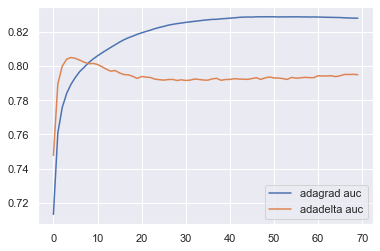

In [97]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad auc', 'adadelta auc'], loc='lower right')
plt.show()

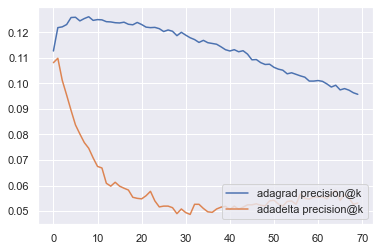

In [98]:
x = np.arange(len(adagrad_k))
plt.plot(x, np.array(adagrad_k))
plt.plot(x, np.array(adadelta_k))
plt.legend(['adagrad precision@k', 'adadelta precision@k'], loc='lower right')
plt.show()

It looks like about 60 epochs provides a good tradeoff between auc and percision@k.

#### Prep and fit model
Turns out that basic collaborative filtering works better than the hybrid model that incorperates item features. The hybrid model is probably better suited for cold start situations.

In [38]:
%%time
model = lt.LightFM(loss='warp',
                  no_components=55,
                  learning_rate=0.03,
                  user_alpha=1e-3,
                  item_alpha=0,
                  random_state=42)

model.fit(SparceInteractions_train,
          #item_features=SparceFeatures,
          epochs=24)

Wall time: 16.6 s


In [152]:
# Evaluate the model (with item features)
t = precision_at_k(model, SparceInteractions_test, item_features=SparceFeatures, k=10).mean()
a = auc_score(model, SparceInteractions_test, item_features=SparceFeatures).mean()

In [153]:
t, a

(0.10337323, 0.7302617)

In [39]:
# Evaluate the model (no item features)
t = precision_at_k(model, SparceInteractions_test, k=10).mean()
a = auc_score(model, SparceInteractions_test).mean()

In [40]:
t, a

(0.12225611, 0.82337856)

### Generate User Predictions with LightFM
Again I'll generate a list of predictions for myself and five other friends to see how effective the recomendations from LightFM are.

In [46]:
def get_user_recommendation(uID, model):
    index = allInteractions.loc[:uID[1]].shape[0] - 1
    
    reco = model.predict(index, np.arange(812))
    reco = pd.DataFrame(reco, index=TrainInteractionsMatrix.columns, columns=['pred'])
    
    mergeDF = LFMdf[['gameName', 'appid']].drop_duplicates()
    reco = reco.merge(mergeDF, how='outer', left_on=reco.index, right_on='appid')
    
    alreadyOwn = dfFull.loc[dfFull.userID==uID[1]]
    reco = reco.loc[~reco.appid.isin(alreadyOwn.appid)]
    
    reco.sort_values(by='pred', ascending=False, inplace=True)
    reco['rank'] = np.arange(reco.shape[0])
    
    
    reco.to_csv("hybrid{}{}TEST.csv".format(uID[0], uID[1]))

In [47]:
get_user_recommendation(('Me', 76561198050349457), model)

In [404]:
uids = [("Max", 76561198043116852), ("Sam", 76561198030495862), ("Flan", 76561198067694858),
        ("Ben", 76561198067474658), ("Julian", 76561198025619021)]
for i in uids:
    get_user_recommendation(i, model)

In the end the basic collaborativ filtering LigthFM model yielded the best results. It performed better in terms of percision@k and there was consistent concensus form the small sample of users who I asked to evaluate the models recommendations that the non hybrid LightFM model performed the best. In the future, it would be a good idea to ask a larger sample of users to rate the models, and find a way to generate auc/precision@k metrics for the suprise library models.